<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/18_4_cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
!wget https://storage.yandexcloud.net/academy.ai/cat-and-dog.zip
!unzip -qo "cat-and-dog" -d ./temp

import os
import shutil
from keras import layers # импортируем слои
from keras import models # импортируем модели
from keras import optimizers  # импортируем функции оптимизации
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_PATH = './temp/training_set/training_set/'
BASE_DIR = './dataset/'
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))
CLASS_COUNT = len(CLASS_LIST)

# При повторном запуске пересоздаим структуру каталогов
# Если папка существует, то удаляем ее со всеми вложенными каталогами и файлами
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)
os.mkdir(BASE_DIR)
train_dir = os.path.join(BASE_DIR, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(BASE_DIR, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(BASE_DIR, 'test')
os.mkdir(test_dir)

# Функция создания подвыборок (папок с файлами)
def create_dataset(
    img_path: str,         # Путь к файлам с изображениями классов
    new_path: str,         # Путь к папке с выборками
    class_name: str,       # Имя класса (оно же и имя папки)
    start_index: int,      # Стартовый индекс изображения, с которого начинаем подвыборку
    end_index: int         # Конечный индекс изображения, до которого создаем подвыборку

):

    src_path = os.path.join(img_path, class_name)  # Полный путь к папке с изображениями класса
    dst_path = os.path.join(new_path, class_name)  # Полный путь к папке с новым датасетом класса
    class_files = os.listdir(src_path)
    os.mkdir(dst_path)

    # Перебираем элементы, отобранного списка с начального по конечный индекс
    for fname in class_files[start_index : end_index]:
        src = os.path.join(src_path, fname)
        dst = os.path.join(dst_path, fname)
        shutil.copyfile(src, dst)

for class_label in range(CLASS_COUNT):    # Перебор по всем классам по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен

    create_dataset(IMAGE_PATH, train_dir, class_name, 0, 1000)
    create_dataset(IMAGE_PATH, validation_dir, class_name, 1000, 1500)
    create_dataset(IMAGE_PATH, test_dir, class_name, 1500, 2000)

--2024-10-05 05:11:54--  https://storage.yandexcloud.net/academy.ai/cat-and-dog.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228082266 (218M) [application/x-zip-compressed]
Saving to: ‘cat-and-dog.zip.16’

cat-and-dog.zip.16  100%[===================>] 217.52M  15.7MB/s    in 16s     

2024-10-05 05:12:12 (13.3 MB/s) - ‘cat-and-dog.zip.16’ saved [228082266/228082266]



In [70]:
import os                                                 # Для работы с файловой системой
import numpy as np                                        # Работа с матрицами
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Импортируем генератор изображений

datagen = ImageDataGenerator(rescale=1./255) # Задаем генератор и нормализуем данные делением на 255
batch_size = 20 # Размер батча (20 изображений)

# Функция извлечения признаков
def extract_features(directory, sample_count):
    # определяем размерность признаков, заполняем нулями
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    # определяем размерность выходных меток, заполняем нулями
    labels = np.zeros(shape=(sample_count))

    # генерируем данные из папки
    generator = datagen.flow_from_directory(
        directory,                # путь к папке
        target_size=(150, 150),   # изменить картинки до размера 150 х 150
        batch_size=batch_size,    # размер пакета
        class_mode='binary'       # задача бинарной классификации
    )
    i = 0
    for inputs_batch, labels_batch in generator: # в цикле пошагово генерируем пакет с картинками и пакет из меток
        features_batch = conv_base.predict(inputs_batch, verbose=0) # делаем предсказание на сгенерируемом пакете
        features[i * batch_size : (i + 1) * batch_size] = features_batch # складываем пакеты с признаками пачками в массив с признаками

        labels[i * batch_size : (i + 1) * batch_size] = labels_batch     # складываем пакеты с метками в массив с метками
        i += 1
        if i * batch_size >= sample_count: # Прерываем генерацию, когда выходим за число желаемых примеров
            break
    return features, labels # возвращаем кортеж (признаки, метки)

train_features, train_labels = extract_features(train_dir, 8000)
validation_features, validation_labels = extract_features(validation_dir, 4000)
test_features, test_labels = extract_features(test_dir, 4000)

train_features = np.reshape(train_features, (8000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (4000, 4 * 4 * 512))
test_features = np.reshape(test_features, (4000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [71]:
from keras.applications import MobileNet
from keras import models
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras import optimizers

def model_maker():
    base_model = MobileNet(include_top=False, input_shape = (150, 150, 3))

    for layer in base_model.layers[:]:
        layer.trainable = False

    input = Input(shape=(150, 150, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)

    return Model(inputs=input, outputs=predictions)

In [77]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# генератор для обучающей выборки
train_datagen = ImageDataGenerator(
    rescale=1./255,           # нормализация данных
    rotation_range=40,        # поворот 40 градусов
    width_shift_range=0.2,    # смещенние изображения по горизонтали
    height_shift_range=0.2,   # смещенние изображения по вертикали
    shear_range=0.2,          # случайный сдвиг
    zoom_range=0.2,           # случайное масштабирование
    horizontal_flip=True,     # отражение по горизонтали
    fill_mode='nearest'       # стратегия заполнения пустых пикселей при трансформации
)
# генератор для проверочной выборки
test_datagen = ImageDataGenerator(rescale=1./255)

# генерация картинок из папки для обучающей выборки
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# генерация картинок из папки для проверочной выборки
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# компиляция модели
model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    metrics=['acc'])

# обучаем модель
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 252ms/step - acc: 0.9791 - loss: 0.0544 - val_acc: 0.9660 - val_loss: 0.1153
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 218ms/step - acc: 0.9840 - loss: 0.0568 - val_acc: 0.9670 - val_loss: 0.1251
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 223ms/step - acc: 0.9865 - loss: 0.0438 - val_acc: 0.9630 - val_loss: 0.1400
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 220ms/step - acc: 0.9870 - loss: 0.0361 - val_acc: 0.9720 - val_loss: 0.1339
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 223ms/step - acc: 0.9882 - loss: 0.0328 - val_acc: 0.9640 - val_loss: 0.1497
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 232ms/step - acc: 0.9820 - loss: 0.0376 - val_acc: 0.9630 - val_loss: 0.2229
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 222ms/step - acc: 0.9900 - loss: 0.0386 - val_acc: 0.9630 - val_loss: 0.1630
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 242ms/step - acc: 0.9852 - loss: 0.0362 - val_acc: 0.9720 - val_loss: 0.1243
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s

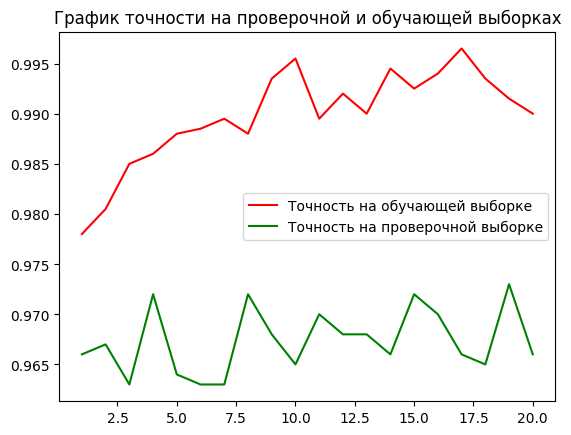

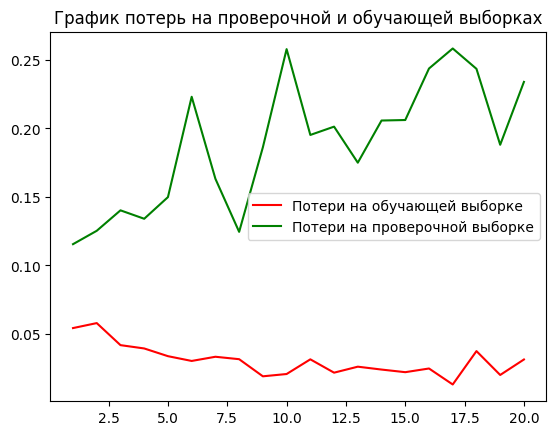

In [86]:
import matplotlib.pyplot as plt

def show_history(store):
    global acc
    global val_acc
    acc = store.history['acc']
    val_acc = store.history['val_acc']
    loss = store.history['loss']
    val_loss = store.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'g', label='Точность на проверочной выборке')
    plt.title('График точности на проверочной и обучающей выборках')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'g', label='Потери на проверочной выборке')
    plt.title('График потерь на проверочной и обучающей выборках')
    plt.legend()
    plt.show()

show_history(history)

In [87]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)

Found 1000 images belonging to 2 classes.
 2/50 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - acc: 0.9750 - loss: 0.4537 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - acc: 0.9529 - loss: 0.4343


In [96]:
print(f"Точность на обучающей выборке: {round((acc[-1])*100, 1)}%")
print(f"Точность на проверочной выборке: {round((val_acc[-1])*100, 1)}%")
print(f"Точность на контрольной выборке: {round((test_acc)*100, 1)}%")

Точность на обучающей выборке: 99.0%
Точность на проверочной выборке: 96.6%
Точность на контрольной выборке: 95.9%
